In [1]:
import math
import scipy
import numpy as np

SIZE=1_000_000

In [2]:
SIGMA_TOTAL_VAR = {}
SIGMA_BITS_PER_COORD = {}

for SIZE in (10_000, 100_000, 1_000_000, 10_000_000):
    left = SIZE / math.log2(SIZE)
    right = SIZE * ( 1 - 1/math.log2(SIZE))

    left_bits_per_coord = 1 + left/SIZE + 32 / SIZE
    right_bits_per_coord = 1 + right/SIZE + 32 / SIZE

    ks_low = np.linspace(1, left, 1000)
    BITS_PER_COORD_LOW = ks_low/SIZE + ks_low / SIZE * np.log2(SIZE) + 32 / SIZE

    ks_mid = np.linspace(left, right, 1000)
    BITS_PER_COORD_MID = 1 + ks_mid/SIZE + 32 / SIZE

    ks_high = np.linspace(right, SIZE-1, 1000)
    BITS_PER_COORD_HIGH = ks_high/SIZE + (SIZE - ks_high) / SIZE * np.log2(SIZE) + 32 / SIZE

    ks = np.concatenate((ks_low, ks_mid, ks_high))

    etas = np.sqrt(2) * scipy.special.erfinv(1 - ks/SIZE)

    s_var = np.sqrt(2/np.pi) * (np.sqrt(np.pi/2) * scipy.special.erf(etas/np.sqrt(2)) - np.exp(-etas**2 / 2) * etas)
    q_var = -2 * np.exp(-etas**2) / (np.pi * scipy.special.erfc(etas/np.sqrt(2))) + scipy.special.erfc(etas/np.sqrt(2)) + np.sqrt(2/np.pi) * np.exp(-etas**2 / 2) * etas

    SIGMA_TOTAL_VAR[SIZE] = s_var + q_var
    SIGMA_BITS_PER_COORD[SIZE] = np.concatenate((BITS_PER_COORD_LOW, BITS_PER_COORD_MID, BITS_PER_COORD_HIGH))

In [28]:
import numpy as np
import math
from functools import cache
from MiniFL.compressors.eden import opt_hn_centroids
from scipy.special import erf


def section_var(a, b, c) -> float:
    if math. isinf(c):
        return np.sqrt(2/np.pi) * np.exp(-a**2/2) * (a - 2*b) - (b**2+1)*erf(a/np.sqrt(2)) + (b**2+1)*erf(c/np.sqrt(2))
    else:
        return np.sqrt(2/np.pi) * np.exp(-a**2/2) * (a - 2*b) - (b**2+1)*erf(a/np.sqrt(2)) + (b**2+1)*erf(c/np.sqrt(2)) + np.sqrt(2/np.pi) * np.exp(-c**2/2) * (2*b - c)

@cache
def bits_var():
    result = {0: 1}
    for bits, centers in opt_hn_centroids.items():
        borders = [0] + [(a + b) / 2 for a, b in zip(centers[:-1], centers[1:])] + [float("inf")]
        variance = sum(section_var(a, b, c) for a, b, c in zip(borders[:-1], centers, borders[1:]))
        result[bits] = variance
    return result


def eden_alpha(bits):
    vars = bits_var()
    bits_low = np.floor(bits)
    bits_high = bits_low + 1

    return (bits_high - bits) * vars[bits_low] + (bits - bits_low) * vars[bits_high]

bits_per_coord = np.linspace(0.001, 4, 1000)
EDEN_BITS_PER_COORD = bits_per_coord + 32/SIZE
EDEN_ALPHAS = [eden_alpha(bits) for bits in bits_per_coord]

In [29]:
def eden_omega(bits):
    if bits < 1:
        return np.pi / (2 * bits) - 1

    vars = bits_var()
    bits_low = np.floor(bits)
    bits_high = bits_low + 1

    vars = bits_var()
    if not isinstance(bits, int):
        return 1 / ( (bits_high - bits)*(1-vars[bits_low]) + (bits - bits_low) * (1-vars[bits_high]) ) - 1
    else:
        return 1 / (1 - vars[self.bits]) - 1

EDEN_OMEGAS = [eden_omega(bits) for bits in bits_per_coord]

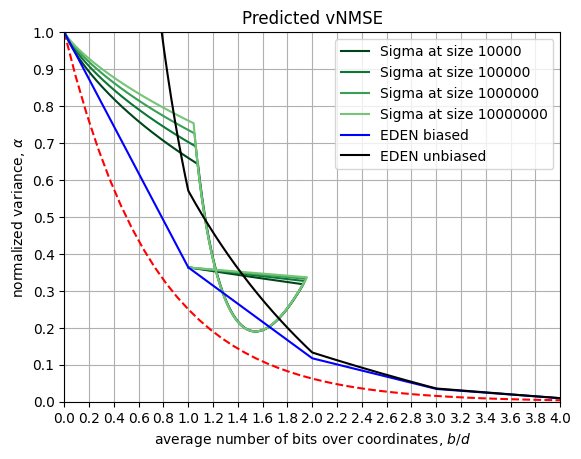

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

x = np.linspace(0, 9, num=100)
y = 4**(-x)
plt.plot(x, y, linestyle="--", color="red")

colors = mpl.colormaps["Greens_r"](np.linspace(0, 0.5, len(SIGMA_BITS_PER_COORD)))

for color, SIZE in zip(colors, SIGMA_BITS_PER_COORD):
    plt.plot(SIGMA_BITS_PER_COORD[SIZE], SIGMA_TOTAL_VAR[SIZE], color=color, label=f"Sigma at size {SIZE}")

plt.plot(EDEN_BITS_PER_COORD, EDEN_ALPHAS, color="blue", label="EDEN biased")
plt.plot(EDEN_BITS_PER_COORD, EDEN_OMEGAS, color="black", label="EDEN unbiased")

plt.xticks([i / 5 for i in range(21)])
plt.yticks([i / 10 for i in range(11)])
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 1)
plt.title(f"Predicted vNMSE")
plt.show()